# Deep Reinforcement Learning - Project 3: Collaboration and Competition

The goal of this project is to teach two autonomous agents to play collaborative tennis, i.e. keeping the ball in play for as long as possible.

---

In [1]:
### Imports

# General
import numpy as np
from scipy.signal import savgol_filter
from collections import namedtuple, deque

import matplotlib.pyplot as plt
%matplotlib inline

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal, Beta

# Unity Environment
from unityagents import UnityEnvironment

## 1. Examine Problem Setup

Check out the specifics of the Tennis environment.

In [2]:
env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# Create agent interface
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [4]:
### Examine problem setup

# Reset the environment
env_info = env.reset(train_mode=False)[brain_name]

# Check number of agents
n_agents = len(env_info.agents)
print("Agent:")
print("=======")
print("Number of agents:", n_agents)
print("- Agent 1 (Red)")
print("- Agent 2 (Blue)")

# Check observation space
obs_dim = brain.vector_observation_space_size
stacked_dim = brain.num_stacked_vector_observations
state_dim = obs_dim*stacked_dim

print("\nObservation Space:")
print("==================")
print("Type                      :", brain.vector_observation_space_type)
print("Size                      :", obs_dim)
print("Stacked observations      :", stacked_dim)
print("Example state vector ({}x{}):\n".format(obs_dim, stacked_dim), env_info.vector_observations[0])

# Check action space
action_dim = brain.vector_action_space_size

print("\nAction Space:")
print("=============")
print("Type   :", brain.vector_action_space_type)
print("Size   :", action_dim)
print("Actions: move (forward/backward), jump [-1, 1]")

# Rewards
print("\nReward Function:")
print("================")
print("Move around                         :  0")
print("Hit ball over net                   : +0.1")
print("Hit ball out of bounds (incl. floor): -0.01")

Agent:
Number of agents: 2
- Agent 1 (Red)
- Agent 2 (Blue)

Observation Space:
Type                      : continuous
Size                      : 8
Stacked observations      : 3
Example state vector (8x3):
 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]

Action Space:
Type   : continuous
Size   : 2
Actions: move (forward/backward), jump [-1, 1]

Reward Function:
Move around                         :  0
Hit ball over net                   : +0.1
Hit ball out of bounds (incl. floor): -0.01


## 2. Define Agents

Build tennis playing agents! 

In this case, the tennis playing agents are defined as policy-based agents.  
Let's try the PPO algorithm and utilize self-play. 

In [5]:
class PPOActorCriticNetwork(nn.Module):

    def __init__(self, state_dim, action_dim, hidden_layer_sizes=[64, 64], seed=0):
        """Initialize network.
        
        Parameters
        ==========
            state_dim          : dimension of state vector            : (int) 
            action_dim         : dimension of action vector           : (int) 
            hidden_layer_sizes : number of nodes in each hidden layer : (list[int]) 
            seed               : random seed                          : (int) 
        """
        
        super().__init__()
        _ = torch.manual_seed(seed)
        
        ### Define neural network architecture
        # The PPO Actor/Critic consists of two NNs sharing weights
        # Only the "heads" (output layers) differ
    
        ### Network body
        
        # Normalize input to improve learning
        self.norm = nn.LayerNorm(state_dim)
        
        # Add layer mapping input (state) to first hidden layer
        self.nn_layers = nn.ModuleList([nn.Linear(state_dim, hidden_layer_sizes[0])])
        
        # Add a variable number of additional hidden layers
        layer_sizes = zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:])
        self.nn_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        ### Network heads
        
        ### Actor: 
        # Actions are modelled with a Beta distribution to allow for some exploring
        # Thus, neural net output is taken as the alpha and beta of the distribution
        self.actor_head_alpha = nn.Linear(hidden_layer_sizes[-1], action_dim)
        self.actor_head_beta = nn.Linear(hidden_layer_sizes[-1], action_dim)

        ### Critic:
        # The critic estimates the value function
        self.critic_head = nn.Linear(hidden_layer_sizes[-1], 1)
        
        
    def forward(self, current_states, actions=None):
        """Do a forward pass through the network.
        
        Parameters
        ==========
            current_states : input vector, i.e. current environment states : (numpy.ndarray[state_dim])
        """
        
        x = torch.Tensor(current_states)
        
        # Normalize input to improve learning stability
        x = self.norm(x)
        
        # Forward states through each layer in the network body, using ReLU activation
        for layer in self.nn_layers:
            x = F.relu(layer(x))
            
        ### Actor: 
        # Create the Beta distribution
        # Alpha and beta parameter should be >=1 to ensure unimodality and convexity. 
        # Thus, pass through a softplus and add 1
        alpha = 1 + F.softplus(self.actor_head_alpha(x))
        beta = 1 + F.softplus(self.actor_head_beta(x))
        dists = torch.distributions.Beta(alpha, beta)
                
        # Sample actions to take (unless supplied)
        if actions is None:
            actions = dists.sample()

        # Calculate the log probabilities of actions
        action_log_probs = dists.log_prob(actions).sum(-1).unsqueeze(-1)
        
        # Calculate dist entropies (used in loss function to encourage exploration)
        dist_entropies = dists.entropy().sum(-1).unsqueeze(-1)

        ### Critic: 
        # Outputs an estimation of the values of the current states
        # (i.e. no activation fcn)
        values = self.critic_head(x)
                
        return values, actions, action_log_probs, dist_entropies
    
    
    def scale_actions(self, actions):
        """Scale actions to environment input range."""
        
        # Beta distribution outputs [0,1]
        # Scale action vector to [-1, 1] 
        return 2 * actions - 1

In [6]:
#######################################################################
# Copyright (C) 2017 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

class PPOAgent:
    
    def __init__(self, state_dim, action_dim, n_agents, hyperparameters, seed=0):
        """Initialize PPO Agent.
        
        Parameters
        ==========
            state_dim          : dimension of state vector                         : (int) 
            action_dim         : dimension of action vector                        : (int) 
            n_agents          : number of parallel workers collecting experiences : (int)
            hidden_layer_sizes : number of nodes in each hidden layer              : (list[int]) 
            seed               : random seed                                       : (int) 
        """

        _ = torch.manual_seed(seed)

        # The environment supports agents running several workers in parallel to collect experiences
        self.n_agents = n_agents
        self.trajectories = []
        
        # Create the common actor/critic (and put it on the GPU if available)
        self.actor_critic = PPOActorCriticNetwork(state_dim, action_dim, 
                                                  hyperparameters["hidden_layer_sizes"], seed).to(device)
        
        # Add an optimizer for weight training
        self.hyperparameters = hyperparameters
        self.optimizer = optim.Adam(self.actor_critic.parameters(), hyperparameters['lr'])


    def get_action_data(self, current_states):
        """Get actions from policy, and related meta-data.

        Params
        ======
            current_states : input vector, i.e. current environment states : (torch.Tensor[state_dim])
         """

        self.actor_critic.eval()
        
        with torch.no_grad():
            
            # Get actions and related data
            values, actions, log_probs, entropies = self.actor_critic(current_states)            
            
        self.actor_critic.train()

        return values, actions, log_probs, entropies


    def collect_trajectories(self, env):
        """Multiple workers of the agent collect experiences in parallel.

        Params
        ======
            env :  environment to train in : (UnityEnvironment)
         """
        
        self.trajectories.clear()

        # Reset environment and observe initial states
        env_info = env.reset(train_mode=True)[brain_name] 
        current_states = env_info.vector_observations
                   
        # Collect trajectories
        episode_time=0
        extra_time=0

        while True:
            
            # Increment timers
            episode_time += 1
            if extra_time > 0:
                extra_time += 1
            
            # Take actions as advised by current policy
            values, actions, log_probs, _ = self.get_action_data(current_states)            
            actions_scaled = self.actor_critic.scale_actions(actions.cpu().detach().numpy())
            env_info = env.step(actions_scaled)[brain_name]

            # Observe feedback from environment
            next_states = env_info.vector_observations 
            rewards = env_info.rewards                 
            dones = env_info.local_done
            
            # Store collected trajectory
            self.trajectories.append([torch.tensor(current_states).float(), values.detach(), actions.detach(), 
                                      log_probs.detach(), rewards, 1 - np.array(dones)])

            # Next time step
            current_states = next_states
            
            # Check if rollout is complete
            if episode_time >= self.hyperparameters["trajectory_horizon"] and np.any(dones):
                
                # First episode end after horizon, start counting extra time
                if extra_time == 0:
                    extra_time = 1
                
            if extra_time > 100:
                # Trajectory collection completed
                break
                
        # We need the estimated value of the last next state 
        # (potentially non-zero if trajectory horizon is not at episode end)
        values, actions, log_probs, _ = self.get_action_data(current_states)

        self.trajectories.append([torch.tensor(current_states), values.detach(), actions.detach(), 
                                  log_probs.detach(), rewards, 1 - np.array(dones)])

        # Learn from collected trajectories
        self.__learn()
        
        
    def __learn(self):
        """Learn from collected trajectories."""
     
        # Compute future returns and advantages for collected trajectories
        # Needed to calculate surrogate objective function
        surrogate_data = []
        t_advantages = torch.Tensor(np.zeros((self.n_agents, 1)))
        
        # Init future returns with last value estimate
        t_future_returns = self.trajectories[-1][1]

        # Step through collected trajectories
        # Ignore past rewards for better credit assignment
        for t in reversed(range(self.hyperparameters["trajectory_horizon"])):
            
            # Extract relevant data from trajectories
            t_states, t_values, t_actions, t_log_probs, t_rewards, t_done_masks = self.trajectories[t]
            t_next_values = self.trajectories[t+1][1]

            # Convert lists to tensors
            t_states = torch.Tensor(t_states)
            t_values = torch.Tensor(t_values)
            t_actions = torch.Tensor(t_actions)
            t_log_probs = torch.Tensor(t_log_probs)
            t_rewards = torch.Tensor(t_rewards).unsqueeze(-1)
            t_done_masks = torch.Tensor(t_done_masks).unsqueeze(-1)
            t_next_values = torch.Tensor(t_next_values)

            t_future_returns = t_rewards + self.hyperparameters["gamma"] * t_done_masks * t_future_returns

            # Compute GAE to use as baseline
            t_td_error = t_rewards + self.hyperparameters['gamma'] * t_done_masks * (t_next_values - t_values)
            t_advantages = t_advantages * self.hyperparameters['lambda'] * self.hyperparameters['gamma'] * t_done_masks + t_td_error
            
            surrogate_data.insert(0, [t_states, t_actions, t_log_probs, t_future_returns, t_advantages])

        # Concatenate trajectories of all agent workers
        states, actions, old_log_probs, future_returns, advantages = map(lambda x: torch.cat(x, dim=0), zip(*surrogate_data))

        # Normalize advantages
        advantages = (advantages - advantages.mean()) / advantages.std()
       
        # Run stochastic gradient ascent for a number of epochs to improve a/c network
        for _ in range(self.hyperparameters['sgd_epochs']):

            # Create a generator for batch indices
            sampler = self.__random_indexer(states.size(0), self.hyperparameters['batch_size'])
            
            # Step thorugh batches
            for batch_indices in sampler:
                batch_indices = torch.Tensor(batch_indices).long()

                # Sample 
                sampled_states = states[batch_indices]
                sampled_actions = actions[batch_indices]
                sampled_old_log_probs = old_log_probs[batch_indices]
                sampled_returns = future_returns[batch_indices]
                sampled_advantages = advantages[batch_indices]

                # Get auxilliary data from states and actions needed for contruction of loss function
                values, _, log_probs, entropies = self.actor_critic(sampled_states, sampled_actions)

                # Calculate surrogate function, which have approximately
                # the same gradient as the policy for small perturbations
                policy_ratio = (log_probs - sampled_old_log_probs).exp()
                surrogate_objective = policy_ratio * sampled_advantages

                # Clip surrogate to make sure it is close to the policy gradient
                clipped_surrogate_objective = \
                    policy_ratio.clamp(1.0 - self.hyperparameters['max_ratio'],
                                       1.0 + self.hyperparameters['max_ratio']) * sampled_advantages

                policy_loss = torch.min(surrogate_objective, clipped_surrogate_objective).mean()

                # Value function error term (MSE), since NN weights are shared
                value_loss = self.hyperparameters['value_fcn_coeff'] * (sampled_returns - values).pow(2).mean()

                # Entropy bonus to encourage exploration
                entropy_bonus = self.hyperparameters['entropy_coeff'] * entropies.mean()

                # Invert sign on total loss, since the optimizer performs gradient descent (and we want to maximize)
                total_loss = -(policy_loss - value_loss + entropy_bonus)

                # Perform backprop and clip gradients to stabilize training
                self.optimizer.zero_grad()
                total_loss.backward()
                nn.utils.clip_grad_norm_(self.actor_critic.parameters(), self.hyperparameters['max_gradient'])
                self.optimizer.step()
                
                
    def __random_indexer(self, max_index, batch_size):
        """A generator for random batch indices.

        Parameters
        ==========
            max_index  : indices to be generated = [0, max_index[ : (int) 
            batch_size : size of indices batch to yield           : (int) 
        """

        indices = np.asarray(np.random.permutation(max_index))

        # Construct a generator for batch indices
        batches = indices[:len(indices) // batch_size * batch_size].reshape(-1, batch_size)

        for batch in batches:
            yield batch

        # If the remaining set is less than batch_size, yield it
        remainder = len(indices) % batch_size
        if remainder:
            yield indices[-remainder:]
            
            
    def save(self, filename):
        """Save agent weights.

        Parameters
        ==========
            filename : filename to save weights : (string)
        """
        torch.save(self.actor_critic.state_dict(), filename)

## 3. Train Agent

Create an agent and train it using experiences from the environment.

In [7]:
# Enable GPU training, if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# A trainer for tennis agents
class AgentTrainer:
    
    def __init__(self, environment, agent):
        """Initialize AgentTrainer.
        
        Parameters
        ==========
            environment :  environment to train in : (UnityEnvironment)
            agent       :  agent to train          : (Agent)
        """
        
        self.env = environment
        self.agent = agent
        
        # Initialize score keeping
        self.all_scores = []                        
        self.latest_scores_window = deque(maxlen=100)  
        
        # Crude adaptive training
        self.training_regime = 1
        
        
    def train_agent(self, n_max_episodes=250, goal_reward=30.0):
        """Train agent in the Tennis Environment

        Parameters
        ==========
            n_max_episodes : maximum number of training episodes                              : (int)
            goal_reward    : average score over 100 episodes before task is considered solved : (int)
         """
        
        # Reset score keeping
        self.all_scores.clear()                        
        self.latest_scores_window.clear()
        goal_met = False
        max_score = 2.0

        # Run through episodes until task is solved
        print("Training agent...")

        for i_episode in range(1, n_max_episodes+1):

            # Collect trajectories
            self.agent.collect_trajectories(self.env)
                   
            # Check mean score over all agent workers with current policy
            max_episode_score = self.evaluate_agent()
            
            # Store episode score
            self.latest_scores_window.append(max_episode_score)      
            self.all_scores.append(max_episode_score)
            latest_mean_score = np.mean(self.latest_scores_window)
            
            # Save agent, if best yet
            if (latest_mean_score > max_score):
                self.agent.save("tennis_player.pth")
                max_score = latest_mean_score


            # Print score statistics
            print("\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}".format(i_episode, max_episode_score, latest_mean_score), 
                                                               end="")
            
            if i_episode % 10 == 0:
                print("\rEpisode {}\tEpisode Score: {:.2f}\tAverage Score: {:.2f}".format(i_episode, max_episode_score, latest_mean_score))

            # Check if task is solved
            if np.mean(self.latest_scores_window) >= goal_reward and not goal_met:
                print("\nTennis solved in {:d} episodes!\n".format(i_episode))
                goal_met = True
                
            # Modify some hyperparameters, if applicable
            self.adjust_training_regime(latest_mean_score)
                                
        return self.all_scores
    
    

    def evaluate_agent(self):
        """Evaluate agent in an episode of the Tennis Environment"""
        
        # Reset environment and observe initial states
        # (Use train=true in this case to speed up)
        env_info = self.env.reset(train_mode=True)[brain_name] 
        current_states = env_info.vector_observations
        episode_scores = np.zeros(self.agent.n_agents)
        
        # Step through an episode
        while True:
            
            # Take actions as advised by policy
            _, actions, _, _  = self.agent.get_action_data(current_states)
            actions_scaled = self.agent.actor_critic.scale_actions(actions.cpu().detach().numpy())
            env_info = env.step(actions_scaled)[brain_name]

            # Observe feedback from environment
            next_states = env_info.vector_observations  
            episode_scores += env_info.rewards      
            dones = env_info.local_done                  

            # Next time step
            current_states = next_states
            
            if np.any(dones):                                    
                # Episode ended
                break

        # Return the max of agent scores according to scoring definition
        return np.max(episode_scores)

    
    def plot_agent_rewards(self, goal_reward):
        """Plot rewards received by the agent during training
        
        Params
        ======
            goal_reward : average score over 100 episodes before task is considered solved : (int)
         """

        # Create smooth version of epsiode scores
        smooth_scores = savgol_filter(self.all_scores, 101, 3)
        
        # Plot the reward evolution over episodes
        fig = plt.figure(figsize=(15,10))

        plt.plot(np.arange(len(self.all_scores)), self.all_scores, label="episode reward evolution")
        plt.plot(np.arange(len(self.all_scores)), smooth_scores, label="smoothed reward evolution")

        plt.title("Tennis Player")
        plt.ylabel("Reward")
        plt.xlabel("Episode #")
        plt.grid(True)
        plt.axhline(y=goal_reward, color="r", linestyle="-", label="goal")
        plt.legend(loc="upper left")

        plt.savefig("RewardPlot.png", bbox_inches="tight")
        plt.show()
    
    
    def adjust_training_regime(self, average_score):
        """Adjust some hyperparameters when score improves."""
          
        if average_score >= 0.8 and self.training_regime == 1:

            # Average score is above 0.8, enter regime 2
            self.agent.hyperparameters['entropy_coeff'] = 0.002
            self.agent.hyperparameters['max_ratio'] = 0.2
            self.agent.hyperparameters['lambda'] = 0.95
            self.agent.hyperparameters['lr'] = 1e-4
            self.agent.optimizer = optim.Adam(self.agent.actor_critic.parameters(), hyperparameters['lr'])
            
            self.training_regime = 2
            print("\nEntered training regime 2.")
            
        elif average_score >= 2.0 and self.training_regime == 2:
            
            # Average score is above 2.0, enter regime 3
            self.agent.hyperparameters['entropy_coeff'] = 0.0001
            self.agent.hyperparameters['max_ratio'] = 0.1
            self.agent.hyperparameters['sgd_epochs'] = 5
            self.agent.hyperparameters['lr'] = 1e-5
            self.agent.optimizer = optim.Adam(self.agent.actor_critic.parameters(), hyperparameters['lr'])
            
            self.training_regime = 3
            print("\nEntered training regime 3.")        

In [9]:
# Goal
GOAL_REWARD = 0.5

# Define agent hyperparameters
hyperparameters = {
    
    # Actor/Critic network
    'hidden_layer_sizes' : [512, 512],
    
    # Trajectory collection
    'trajectory_horizon': 2048, 

    # Training
    'sgd_epochs': 10,
    'batch_size': 256,
    'lr': 5e-4,
    'max_gradient': 5.0, 

    # Surrogate loss function
    'gamma': 0.995, 
    'lambda': 0.9, # GAE
    'max_ratio': 0.3,
    'value_fcn_coeff': 0.5, 
    'entropy_coeff': 0.003
}

In [10]:
# Instantiate agent tackling tennis playing
agent = PPOAgent(state_dim, action_dim, n_agents, hyperparameters, seed=0)

In [11]:
# Create an agent trainer
agent_trainer = AgentTrainer(env, agent)

In [12]:
# Train agent 
_ = agent_trainer.train_agent(n_max_episodes=500, goal_reward=GOAL_REWARD)

Training agent...
Episode 10	Episode Score: 0.00	Average Score: 0.04
Episode 20	Episode Score: 0.10	Average Score: 0.05
Episode 30	Episode Score: 0.00	Average Score: 0.10
Episode 40	Episode Score: 0.70	Average Score: 0.17
Episode 50	Episode Score: 1.00	Average Score: 0.28
Episode 59	Episode Score: 2.70	Average Score: 0.53
Tennis solved in 59 episodes!

Episode 60	Episode Score: 0.00	Average Score: 0.52
Episode 70	Episode Score: 0.50	Average Score: 0.53
Episode 80	Episode Score: 2.60	Average Score: 0.54
Episode 90	Episode Score: 0.20	Average Score: 0.57
Episode 100	Episode Score: 1.60	Average Score: 0.63
Episode 110	Episode Score: 0.70	Average Score: 0.80
Episode 111	Episode Score: 2.60	Average Score: 0.82
Entered training regime 2.
Episode 120	Episode Score: 2.70	Average Score: 0.95
Episode 130	Episode Score: 2.60	Average Score: 1.13
Episode 140	Episode Score: 2.70	Average Score: 1.33
Episode 150	Episode Score: 0.10	Average Score: 1.43
Episode 160	Episode Score: 0.10	Average Score: 1.4

## 4. Evaluate Agent

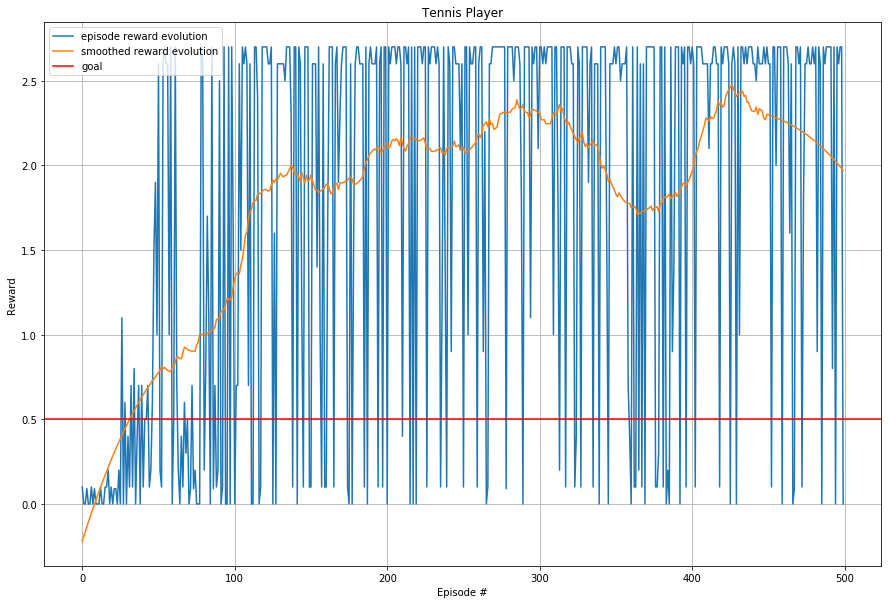

In [13]:
# Plot the reward evolution of the agent during training
agent_trainer.plot_agent_rewards(GOAL_REWARD)

In [15]:
# Load trained agent
agent = PPOAgent(state_dim, action_dim, n_agents, hyperparameters, seed=0)
actor_critic = PPOActorCriticNetwork(state_dim, action_dim, [512, 512])
actor_critic.load_state_dict(torch.load("./tennis_player.pth"))
agent.actor_critic = actor_critic
agent_trainer.agent = agent

# Play 10 matches with the trained agent
for n_match in range(1, 11):

    max_episode_score = agent_trainer.evaluate_agent()
    print("Match {}: Score={:.2f}".format(n_match, max_episode_score))

Match 1: Score=1.80
Match 2: Score=2.60
Match 3: Score=2.70
Match 4: Score=2.70
Match 5: Score=0.00
Match 6: Score=2.60
Match 7: Score=2.70
Match 8: Score=2.70
Match 9: Score=2.70
Match 10: Score=0.00


In [16]:
# Close Unity Environment
env.close()

---

## END